# Cycle GANs Implementation (Notebook)

In [ ]:
# Import the relevant libraries
from PIL import Image
import os
import sys
import numpy as np
import random
import copy

import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomHorizontalFlip
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from tqdm import tqdm

## Define a custom dataset

In [ ]:
class myDataset(Dataset):
    def __init__(self, root_A, root_B, transform=None):
        self.root_A = root_A
        self.root_B = root_B
        self.transform = transform

        self.A_images = os.listdir(root_A)
        self.B_images = os.listdir(root_B)
        
        self.length_dataset = max(len(self.A_images), len(self.B_images))
        self.A_len = len(self.A_images)
        self.B_len = len(self.B_images)
        
    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        A_img = self.A_images[index % self.A_len]
        B_img = self.B_images[index % self.B_len]
        
        A_path = os.path.join(self.root_A, A_img)
        B_path = os.path.join(self.root_B, B_img)
        
        A_img = Image.open(A_path).convert("RGB")
        B_img = Image.open(B_path).convert("RGB")
        
        if self.transform:
            A_img = self.transform(A_img)
            B_img = self.transform(B_img)

        return A_img, B_img

## Apply transformation to the dataset and define a data loader

In [ ]:
transforms = Compose(
    [Resize((256, 256)),
     ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dataset = myDataset(
    root_A="./data/train/A_train", 
    root_B="./data/train/B_train", 
    transform=transforms
)

loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True
)

## Visualize the dataset

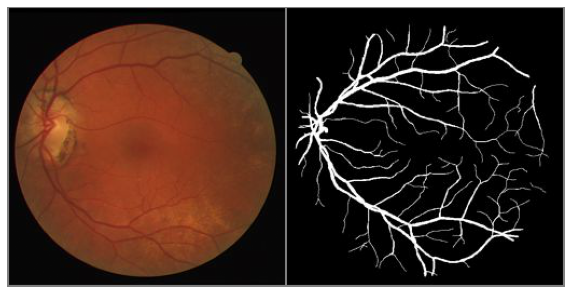

In [ ]:
import matplotlib.pyplot as plt

def show_img(img, size=10):
  img = img*0.5 + 0.5     
  plt.figure(figsize=(size, size))
  plt.imshow(img.permute(1, 2, 0))
  plt.axis('off')
  plt.show()

pic_size = 6

dataiter = iter(loader)
images = dataiter.next()

show_img(make_grid([np.squeeze(images[0]), np.squeeze(images[1])], size=pic_size))

## Define the Cycle-GAN model

### Define the Discriminator model

In [ ]:
# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_channels, out_channels, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # C64 -> C128 -> C256 -> C512
        self.model = nn.Sequential(
            *discriminator_block(channels, out_channels=64, normalize=False),
            *discriminator_block(64, out_channels=128),
            *discriminator_block(128, out_channels=256),
            *discriminator_block(256, out_channels=512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, padding=1)
        )

    def forward(self, img):
        return self.model(img)


### Define the Generator

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channel):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), 
            nn.Conv2d(in_channel, in_channel, 3),
            nn.InstanceNorm2d(in_channel),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channel, in_channel, 3),
            nn.InstanceNorm2d(in_channel),
        )

    def forward(self, x):
        return x + self.block(x)

# Define the generator
class Generator(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(Generator, self).__init__()

        channels = input_shape[0]

        out_channels = 64

        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_channels, 7),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        in_channels = out_channels

        # Downsampling
        # d128 => d256
        for _ in range(2):
            out_channels *= 2
            model += [
                nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels = out_channels

        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_channels)]

        # Upsampling
        # u128 => u64
        for _ in range(2):
            out_channels //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels = out_channels

        # Output layer
        model += [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(out_channels, channels, 7),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

## Define the training function

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 5.0

def train_fn(disc_A, disc_B, gen_AB, gen_BA, loader, opt_disc, opt_gen, l1, mse):
    A_reals = 0
    A_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (A, B) in enumerate(loop):
        A = A.to(device)
        B = B.to(device)
        
        # Train Discriminators A and B
        with torch.cuda.amp.autocast():
            fake_A = gen_BA(B)
            D_A_real = disc_A(A)
            D_A_fake = disc_A(fake_A.detach())
            A_reals += D_A_real.mean().item()
            A_fakes += D_A_fake.mean().item()
            D_A_real_loss = mse(D_A_real, torch.ones_like(D_A_real))
            D_A_fake_loss = mse(D_A_fake, torch.zeros_like(D_A_fake))
            D_A_loss = D_A_real_loss + D_A_fake_loss

            fake_B = gen_AB(A)
            D_B_real = disc_B(B)
            D_B_fake = disc_B(fake_B.detach())
            D_B_real_loss = mse(D_B_real, torch.ones_like(D_B_real))
            D_B_fake_loss = mse(D_B_fake, torch.zeros_like(D_B_fake))
            D_B_loss = D_B_real_loss + D_B_fake_loss

            # put it togethor
            D_loss = (D_A_loss + D_B_loss)/2

        opt_disc.zero_grad()
        D_loss.backward()
        opt_disc.step()

        # Train Generators H and Z
        with torch.cuda.amp.autocast():

            # adversarial loss for both generators
            D_A_fake = disc_A(fake_A)
            D_B_fake = disc_B(fake_B)
            loss_G_A = mse(D_A_fake, torch.ones_like(D_A_fake))
            loss_G_B = mse(D_B_fake, torch.ones_like(D_B_fake))

            loss_gan = (loss_G_A + loss_G_B) / 2

            # cycle loss
            cycle_B = gen_AB(fake_A)
            cycle_A = gen_BA(fake_B)
            cycle_B_loss = l1(cycle_B, B)
            cycle_A_loss = l1(cycle_A, A)

            loss_cycle = (cycle_A_loss + cycle_B_loss) / 2

            # identity loss (remove these for efficiency if you set lambda_identity=0)
            identity_B = gen_AB(B)
            identity_A = gen_BA(A)
            identity_B_loss = l1(identity_B, B)
            identity_A_loss = l1(identity_A, A)
            
            loss_identity = (identity_A_loss + identity_B_loss) / 2

            # add all together
            G_loss = loss_gan + loss_cycle * LAMBDA_CYCLE + loss_identity * LAMBDA_IDENTITY
            
        opt_gen.zero_grad()
        G_loss.backward()
        opt_gen.step()

        save_image(fake_A*0.5+0.5, f"./saved_images/A_{idx}.png")
        save_image(fake_B*0.5+0.5, f"./saved_images/B_{idx}.png")


### Initialize the Generator and the Discriminator models

In [ ]:
input_shape = (3,256,256)
disc_A = Discriminator(input_shape).to(device)
disc_B = Discriminator(input_shape).to(device)
gen_AB = Generator(input_shape, num_residual_blocks=19).to(device)
gen_BA = Generator(input_shape, num_residual_blocks=19).to(device)

### Set the optimizer and the loss functions

In [ ]:
LEARNING_RATE = .0002

optimizer_disc = optim.Adam(
    list(disc_A.parameters()) + list(disc_B.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

optimizer_gen = optim.Adam(
    list(gen_AB.parameters()) + list(gen_BA.parameters()),
    lr = LEARNING_RATE,
    betas=(0.5, 0.999),
)

L1 = nn.L1Loss()
mse = nn.MSELoss()

## Train the Model

In [ ]:
NUM_EPOCHS = 200

for epoch in range(NUM_EPOCHS):
    train_fn(disc_A, disc_B, gen_AB, gen_BA, loader, optimizer_disc, optimizer_gen, L1, mse)

100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


### Visualize the results

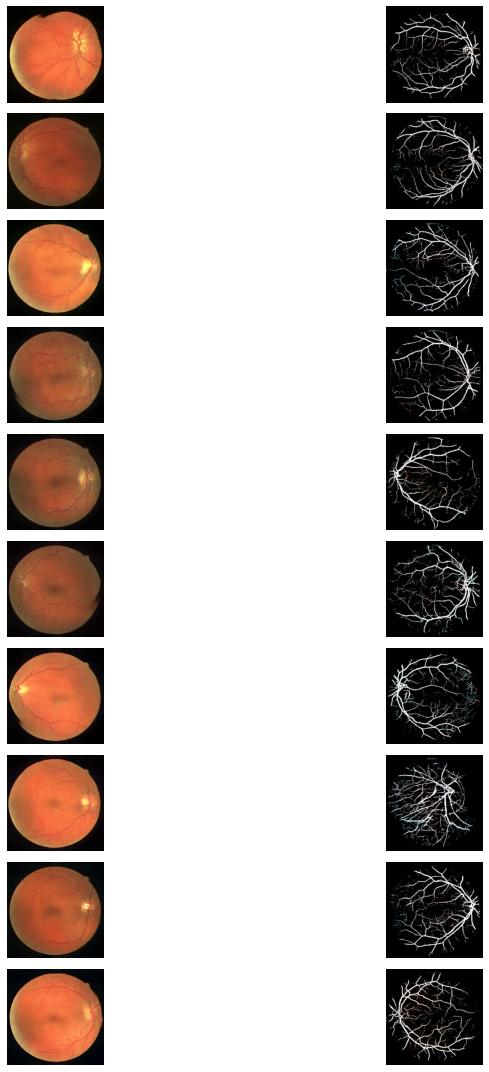

In [ ]:
figure, ax = plt.subplots(10,2, figsize=(15,15))

for i in range(10):
  img_A = np.array(Image.open(f"./saved_images/A_{i}.png"))
  img_B = np.array(Image.open(f"./saved_images/B_{i}.png"))
  ax[i,0].imshow(img_A)
  ax[i,0].set_axis_off()
  ax[i,1].imshow(img_B)
  ax[i,1].set_axis_off()


figure.tight_layout()
plt.show()